In [1]:
import sys
sys.path.append('../src')

import requests
import re

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

qtrs = {1: 'first', 2: 'second', 3: 'third', 4: 'fourth'}

In [2]:
s = {'IP.B00004.S': 'Manufacturing',
     'IP.G21.S': 'Mining',
     'IP.GMFD.S': 'Durable manufacturing',
     'IP.GMFN.S': 'Nondurable manufacturing',
     'IP.B51000.S': 'Consumer goods',
     'IP.B52000.S': 'Equipment, total',
     'IP.B53000.S': 'Materials',
     'IP.B54000.S': 'Nonindustrial supplies',
     'IP.B50001.S': 'Total index',
     'IP.G311A2.S': 'Food, beverage, and tobacco',
     'IP.G325.S': 'Chemical',
     'IP.G3361T3.S': 'Motor vehicles and parts',
     'IP.B51110.S': 'Automotive products',
     'IP.B51211.S': 'Foods and tobacco',
     'IP.B51220.S': 'Consumer energy products',
     'IP.B52110.S': 'Transit equipment',
     'IP.B52120.S': 'Information processing and related equipment',
     'IP.B52131.S': 'Industrial equipment',
     'IP.B52200.S': 'Oil and gas well drilling and manufactured homes',
     'IP.B53110.S': 'Consumer parts',
     'IP.B53120.S': 'Equipment parts',
     'IP.B53131.S': 'Basic metals',
     'IP.B53210.S': 'Textile materials',
     'IP.B53220.S': 'Paper materials',
     'IP.B53230.S': 'Chemical materials',
     'IP.B53300.S': 'Energy materials',
     'IP.B54100.S': 'Construction supplies',
     'IP.B54220.S': 'Commercial energy products',
     'IP.G2211A2.S': 'Utilities'}

srs = [i[3:-2] for i in s.keys()]

In [3]:
ipdata = 'https://www.federalreserve.gov/datadownload/Output.aspx?rel=G17&series=f97ad3652d87a6c1720943c31423103a&lastobs=&from=01/01/1988&to=12/31/2019&filetype=csv&label=include&layout=seriescolumn'
ipweights = 'https://www.federalreserve.gov/releases/g17/ipdisk/ipweights_sa.txt'

In [4]:
header = ['Series', 'Year', 'January', 'February', 'March', 'April', 
          'May', 'June', 'July', 'August', 'September', 'October', 
          'November', 'December']
ipw = pd.read_csv(ipweights, sep='\s+', skiprows=1)
ipw.columns = header
wgt = ipw[ipw['Series'].isin(srs)].set_index(['Series', 'Year']).stack().reset_index()
wgt['Date'] = wgt['level_2'] + ' 01, ' + wgt['Year'].astype('int').astype('str')
wgt['Date'] = pd.to_datetime(wgt['Date'])
wgt = wgt.set_index(['Series', 'Date'])[0]
s_list = list(set(list(f'IP.{s}.S' for s, t in wgt.index)))
wgt = wgt.unstack().T.rename({k[3:-2]: v for k, v in s.items()}, axis=1).loc['1988':]

In [5]:
df = pd.read_csv(ipdata, skiprows=5, index_col=0)[s.keys()].rename(s, axis=1)
df.index = pd.to_datetime(df.index)

In [6]:
df[['Manufacturing', 'Total index']].loc['1989':].to_csv(data_dir / 'indpro.csv', index_label='date')

In [7]:
mf3y = ((df['Manufacturing'].pct_change(36).iloc[-1] + 1)**(1/3)-1) * 100
tot3y = ((df['Total index'].pct_change(36).iloc[-1] + 1)**(1/3)-1) * 100
si = series_info(df['Manufacturing'])
datelt = si['date_latest_ft']
max_diff = (si['val_latest'] / si['val_max'] - 1) * 100

In [8]:
text = f'Manufacturing production increased at an average annual rate of {mf3y:.1f} percent over the past three years, as of {datelt}. The total industrial production index grew at an annual rate of {tot3y:.1f} percent over the same period. Manufacturing production is currently {abs(max_diff):.1f} percent below its peak in {si["date_max_ft"]}'

In [9]:
write_txt(text_dir / 'indpro.txt', text)

In [10]:
text

'Manufacturing production increased at an average annual rate of 1.0 percent over the past three years, as of October 2019. The total industrial production index grew at an annual rate of 2.1 percent over the same period. Manufacturing production is currently 5.5 percent below its peak in December 2007'

In [11]:
for i in [df, wgt]:
    i['ENS'] = i['Equipment, total'] + i['Nonindustrial supplies']
    i['Util'] = i['Total index'] - i['Manufacturing'] - i['Mining']

In [12]:
final = pd.DataFrame()
for s_name in ['Consumer goods', 'ENS', 'Materials']:
    for date in df[s_name].index:
        s_wgt = wgt[s_name].loc[date] / 100.0
        val = (df[s_name].pct_change(12).loc[date])*100
        final.at[date, s_name] = val * s_wgt

final = final.loc['1989':]

In [13]:
final.loc['2015':].to_csv(data_dir / 'indprogr_rec.csv', index_label='date')

In [14]:
(final.resample('QS').mean().loc[:'2019-07-01']
      .to_csv(data_dir / 'indprogr.csv', index_label='date'))

In [15]:
final = pd.DataFrame()
for s_name in ['Durable manufacturing', 'Mining', 'Nondurable manufacturing', 'Utilities']:
    for date in df[s_name].index:
        s_wgt = wgt[s_name].loc[date] / 100.0
        val = (df[s_name].pct_change(12).loc[date])*100
        final.at[date, s_name] = val * s_wgt

final = final.loc['1989':]

In [16]:
final.loc['2015':].to_csv(data_dir / 'indprogr_rec2.csv', index_label='date')

In [17]:
(final.resample('QS').mean().loc[:'2019-07-01']
      .to_csv(data_dir / 'indprogr2.csv', index_label='date'))

In [18]:
%matplotlib inline

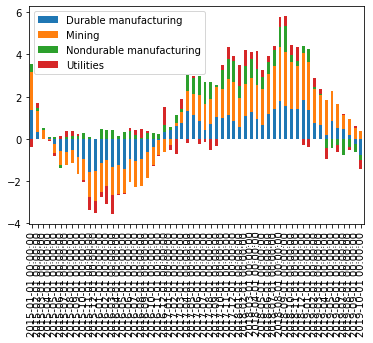

In [19]:
final.loc['2015':].plot(kind='bar', stacked=True)

In [21]:
final = pd.DataFrame()
for s_name in ['Manufacturing', 'Mining', 'Utilities']:
    for date in df[s_name].index:
        s_wgt = wgt[s_name].loc[date] / 100.0
        val = (df[s_name].pct_change(12).loc[date])*100
        final.at[date, s_name] = val * s_wgt

final = final.loc['1989':]

In [22]:
final

,Manufacturing,Mining,Utilities
1989-01-01,3.203931,-0.024653,-0.133734
1989-02-01,2.130327,-0.166204,0.151719
1989-03-01,1.832124,-0.166474,0.477063
1989-04-01,1.318149,0.005298,0.292704
1989-05-01,0.713874,-0.032536,0.378878
...,...,...,...
2019-06-01,0.135233,1.172010,-0.360636
2019-07-01,-0.433410,0.680454,0.066629
2019-08-01,-0.308691,0.754693,-0.133615
2019-09-01,-0.705722,0.491421,0.100114
